# Introduction

The present notebook is a replication of the article https://builtin.com/data-science/propensity-score-matching of Zolzaya Luvsandorj explaining the concrete implementation of the statistical method of prospensity Score matching.

Propensity score matching is a non-experimental causal inference technique that attempts to balance the treatment groups on confounding factors to make them comparable. This allows users to draw conclusions about the causal impact of a treatment on the outcome using observational data.
 <br><br>
 Important if AB Testing is not feasible or simply not an option<br><br>

 <img src="./imgs/01_img.PNG"/>

 <img src="./imgs/02_img.PNG"/>

 <img src="./imgs/03_img.PNG"/>

# Overview

1) Import libraries 
2) Collect the data
3) Estimate propensity scores
4) Match records
5) Evaluate matching
6) Evaluate treatment effect on the outcome

# 1. Import libraries

In [60]:
import pandas as pd
pd.options.display.float_format = "{:.2f}".format

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context = "talk")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from causalinference import CausalModel

# 2. Collect the data

* most important step of the causal analysis
* goal: collect data on all possible confounders based on domain expertise (if left out, risk of false conclusion)
* for temporal data, the temporal confounders should show their state prior to the treatment and the temporal outcome should be captured post-treatment

In this example, the titanic dataset is used with a reduced number of features to keep things manageable:

 <img src="./imgs/04_img.PNG"/>

In [61]:
df = pd.read_excel("titanic3.xls")

In [62]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.34,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.55,C22 C26,S,NaN,135.00,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [63]:
df["is_pclass3"] = df["pclass"] == 3
df["is_female"] = df["sex"] == 'female'

In [64]:
relevant_columns = ["survived", "is_pclass3", "is_female", "age"]
df = df[relevant_columns].copy().dropna().reset_index(drop = True)

In [65]:
df

,survived,is_pclass3,is_female,age
0,1,False,True,29.00
1,1,False,False,0.92
2,0,False,True,2.00
3,0,False,False,30.00
4,0,False,True,25.00
...,...,...,...,...
1041,0,True,False,45.50
1042,0,True,True,14.50
1043,0,True,False,26.50
1044,0,True,False,27.00


In [66]:
TREATMENT = "is_pclass3"
OUTCOME = "survived"

df.groupby(TREATMENT)[OUTCOME].describe()

,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,545.00,0.54,0.50,0.00,0.00,1.00,1.00,1.00
True,501.00,0.26,0.44,0.00,0.00,0.00,1.00,1.00


* Third class passenger's (treatment group) survival rate is 24 %
* other classes (control group) have a survival rate of 54 %

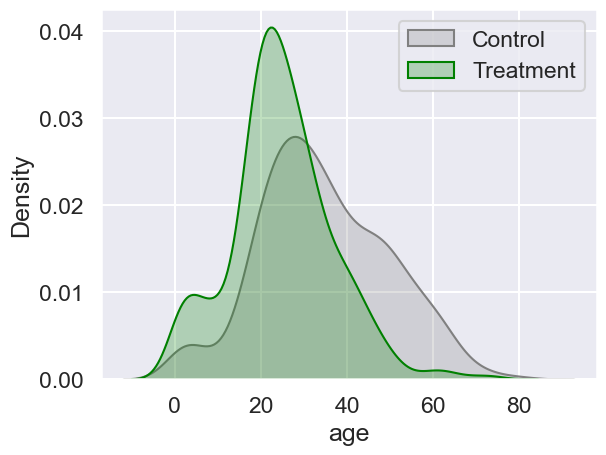

In [67]:
C_COLOUR = "grey"
T_COLOUR = "green"
C_LABEL = "Control"
T_LABEL = "Treatment"

sns.kdeplot(data = df[~df[TREATMENT]], x = "age", fill = True, color = C_COLOUR, label = C_LABEL)
sns.kdeplot(data=df[df[TREATMENT]], x='age', fill=True,color=T_COLOUR, label=T_LABEL)
plt.legend();

* Treatment group has more younger passengers

In [68]:
df

,survived,is_pclass3,is_female,age
0,1,False,True,29.00
1,1,False,False,0.92
2,0,False,True,2.00
3,0,False,False,30.00
4,0,False,True,25.00
...,...,...,...,...
1041,0,True,False,45.50
1042,0,True,True,14.50
1043,0,True,False,26.50
1044,0,True,False,27.00


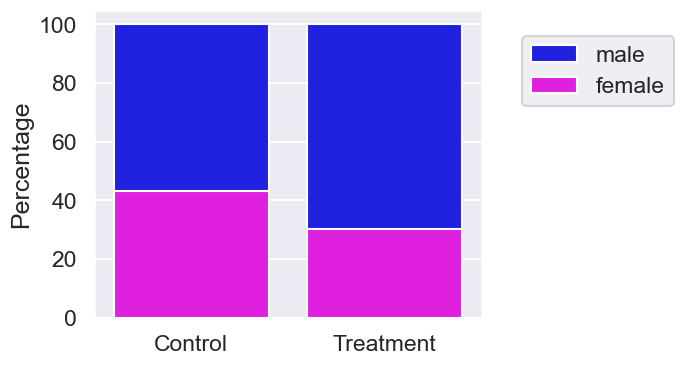

In [69]:
F_COLOUR = 'magenta'
M_COLOUR = 'blue'
F_LABEL = 'female'
M_LABEL = 'male'
gender = 100 * pd.crosstab(df[TREATMENT].replace({True: T_LABEL, 
                                                  False: C_LABEL}), 
                           df['is_female'].replace({True: 'female',
                                                    False: 'male'}), 
                           normalize='index')
gender['All'] = 100
plt.figure(figsize=(5, 4))
sns.barplot(data=gender, x=gender.index.astype(str),  y="All", 
            color=M_COLOUR, label=M_LABEL)
sns.barplot(data=gender, x=gender.index.astype(str),  y='female', 
            color=F_COLOUR, label=F_LABEL)
plt.legend(loc='center', bbox_to_anchor=(1.3, 0.8))
plt.xlabel('')
plt.ylabel('Percentage');


* treatment group has more males
* confounding factors are not balanced between the two groups, it's naive to say that the difference in survival is due to the treatment at this stage
* how to make the groups more comparable? 

# 3. Estimate the propensity score

* after collecting the data, it's possible to build the propensity model predicting the probability of receiving the treatment given the confounders
* typically calculated via logistic regression

In [70]:
t = df[TREATMENT]
X = pd.get_dummies(df.drop(columns = [OUTCOME, TREATMENT]))

In [71]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logistic_classifier", LogisticRegression())
])

In [72]:
pipe.fit(X, t)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

In [73]:
threshold = 0.5
df["proba"] = pipe.predict_proba(X)[:, 1]
df["logit"] = df["proba"].apply(lambda p: np.log(p/(1-p)))
df["pred"] = np.where(df["proba"] >= threshold, 1, 0)

> Propensity score tells us the probability of an individual getting the treatment given the confounders.

In [74]:
df

,survived,is_pclass3,is_female,age,proba,logit,pred
0,1,False,True,29.00,0.37,-0.53,0
1,1,False,False,0.92,0.86,1.80,1
2,0,False,True,2.00,0.73,0.99,1
3,0,False,False,30.00,0.54,0.16,1
4,0,False,True,25.00,0.42,-0.30,0
...,...,...,...,...,...,...,...
1041,0,True,False,45.50,0.33,-0.72,0
1042,0,True,True,14.50,0.57,0.29,1
1043,0,True,False,26.50,0.59,0.35,1
1044,0,True,False,27.00,0.58,0.32,1


In [75]:
print(f"Accuracy: {np.mean(df[TREATMENT]==df['pred']):.4f},\
 ROC AUC: {roc_auc_score(df[TREATMENT], df['proba']):.4f},\
 F1-score: {f1_score(df[TREATMENT], df['pred']):.4f}")
# Visualise confusion matrix
pd.crosstab(df[TREATMENT], df['pred']).rename(columns={0: False, 
                                                       1:True})

Accuracy: 0.6597, ROC AUC: 0.7192, F1-score: 0.6496


pred,False,True
is_pclass3,,
False,360,185
True,171,330


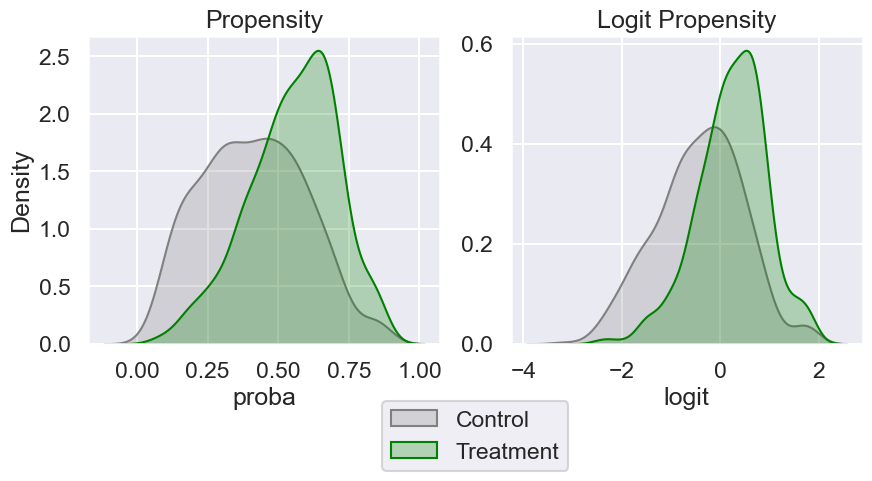

In [76]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
# Visualise propensity
sns.kdeplot(data=df[~df[TREATMENT]], x='proba', fill=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[0])
sns.kdeplot(data=df[df[TREATMENT]], x='proba', fill=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[0])
ax[0].set_title('Propensity')
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
# Visualise logit propensity
sns.kdeplot(data=df[~df[TREATMENT]], x='logit', fill=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[1])
sns.kdeplot(data=df[df[TREATMENT]], x='logit', fill=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[1])
ax[1].set_title('Logit Propensity')
ax[1].set_ylabel("");

We can see that both groups have some overlap in their propensity scores across the range. This is good when it comes to matching.



# 4. Match Records

* we are going to match the most similar control records to the passengers in the treatment group 
* finding similar records in one dimension (propensity score) is much easier than doing it in many dimensions (cofounders)
* propensity score is a balancing score
* if we match records based on the propensity score, the distribution of the confounders between matched records will likely be similar

The following script is used to find a control record with the most similar propensity score for each example in the treatment group (one-to-one matching). doing so, we'll sample the control records with replacement. 
This means some control records can be matched multiple times to different treatment records, whereas some control records are not matched at all

In [85]:
i

1044

In [86]:
n

1045

In [87]:
df.shape

(1046, 9)

In [93]:
df.sort_values('logit', inplace=True)
n = len(df)-1
for i, (ind, row) in enumerate(df.iterrows()): 
    # Match the most similar untreated record to each treated record
    if row[TREATMENT]:
        # Find the closest untreated match among records sorted 
        # higher. 'equal_or_above would' be more accurate but 
        # used 'above' for brevity        
        if i<n:

            try:
                above = df.iloc[i:]
                control_above = above[~above[TREATMENT]]
                match_above = control_above.iloc[0]
                distance_above = match_above['logit'] - row['logit']
                df.loc[ind, 'match'] = match_above.name
                df.loc[ind, 'distance'] = distance_above
            except:
                match_above = None
                distance_above = None

        # Find the closest untreated match among records sorted 
        # lower. 'equal_or_below' would be more accurate but 
        # used 'below' for brevity  
        if i>0:
            below = df.iloc[:i-1]
            control_below = below[~below[TREATMENT]]
            match_below = control_below.iloc[-1]
            distance_below = match_below['logit'] - row['logit']
            
            if i==n:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below
            
            # Only overwrite if match_below is closer than match_above
            elif match_above is None:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below

            elif distance_below<distance_above:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below
df[df[TREATMENT]]

,survived,is_pclass3,is_female,age,proba,logit,pred,match,distance
1010,1,True,True,63.00,0.08,-2.45,0,251.00,0.00
994,0,True,False,74.00,0.09,-2.33,0,6.00,-0.12
666,0,True,False,70.50,0.11,-2.13,0,119.00,-0.03
716,0,True,False,65.00,0.14,-1.82,0,248.00,-0.01
736,0,True,True,48.00,0.17,-1.60,0,462.00,-0.05
...,...,...,...,...,...,...,...,...,...
914,0,True,False,1.00,0.86,1.79,1,444.00,0.00
556,1,True,False,0.83,0.86,1.80,1,496.00,0.00
923,0,True,False,0.75,0.86,1.81,1,320.00,-0.00
999,1,True,False,0.42,0.86,1.82,1,320.00,-0.02


* very simple version of matching 
* there are more sophisticaed matching techniques 
* now create a matched df that contains the original treatment group and a new control group

In [99]:
indices = df[df["match"].notna()].index.append(pd.Index(df.loc[df["match"].notna(), "match"]))

In [112]:
matched_df = df.loc[indices].reset_index(drop = True)

In [113]:
matched_df

,survived,is_pclass3,is_female,age,proba,logit,pred,match,distance
0,1,True,True,63.00,0.08,-2.45,0,251.00,0.00
1,0,True,False,74.00,0.09,-2.33,0,6.00,-0.12
2,0,True,False,70.50,0.11,-2.13,0,119.00,-0.03
3,0,True,False,65.00,0.14,-1.82,0,248.00,-0.01
4,0,True,True,48.00,0.17,-1.60,0,462.00,-0.05
...,...,...,...,...,...,...,...,...,...
997,1,False,False,1.00,0.86,1.79,1,NaN,NaN
998,1,False,False,0.83,0.86,1.80,1,NaN,NaN
999,1,False,False,0.83,0.86,1.80,1,NaN,NaN
1000,1,False,False,0.83,0.86,1.80,1,NaN,NaN


This new control group should be more similar to the treatment group according to the confounding factors

# 5. Evaluate the quality of the matched records

In [115]:
COLUMNS = ["age", "is_female", OUTCOME]

matches = pd.merge(
    left = df.loc[df[TREATMENT], COLUMNS +["match"]],
    right = df[COLUMNS],
    left_on="match",
    right_index=True,
    how = "left",
    suffixes=("_t", "_c")
)

In [116]:
matches

,age_t,is_female_t,survived_t,match,age_c,is_female_c,survived_c
1010,63.00,True,1,251.00,63.00,True,0
994,74.00,False,0,6.00,63.00,True,1
666,70.50,False,0,119.00,71.00,False,0
716,65.00,False,0,248.00,52.00,True,1
736,48.00,True,0,462.00,62.00,False,0
...,...,...,...,...,...,...,...
914,1.00,False,0,444.00,1.00,False,1
556,0.83,False,1,496.00,0.83,False,1
923,0.75,False,0,320.00,0.83,False,1
999,0.42,False,1,320.00,0.83,False,1


In [117]:
for var in ['logit', 'age']:
    print(f"{var} | Before matching")
    display(df.groupby(TREATMENT)[var].describe())
    print(f"{var} | After matching")
    display(matched_df.groupby(TREATMENT)[var].describe())

logit | Before matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,545.00,-0.42,0.89,-3.18,-0.97,-0.36,0.16,1.81
True,501.00,0.22,0.71,-2.45,-0.18,0.27,0.66,1.83


logit | After matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,501.00,0.21,0.71,-2.45,-0.18,0.27,0.66,1.81
True,501.00,0.22,0.71,-2.45,-0.18,0.27,0.66,1.83


age | Before matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,545.00,34.54,14.91,0.67,24.00,33.00,45.00,80.00
True,501.00,24.82,11.96,0.17,18.00,24.00,32.00,74.00


age | After matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,501.00,25.04,12.28,0.67,18.00,24.00,32.00,71.00
True,501.00,24.82,11.96,0.17,18.00,24.00,32.00,74.00


The distribution looks more similar between the groups now after the matching. Let’s visualize the distributions:



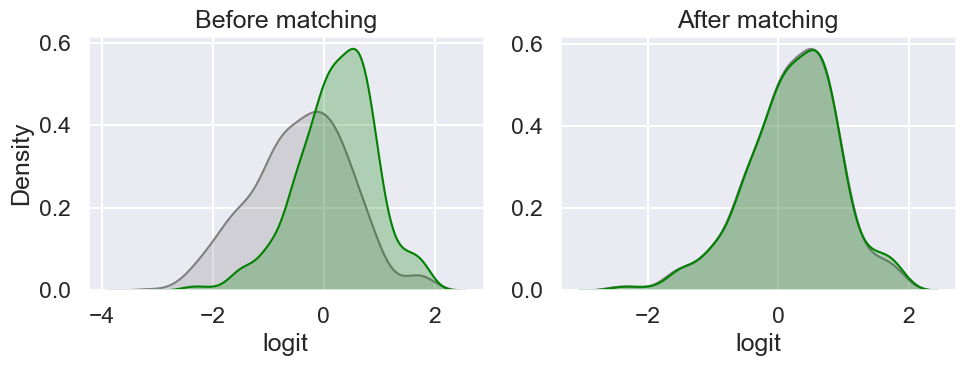

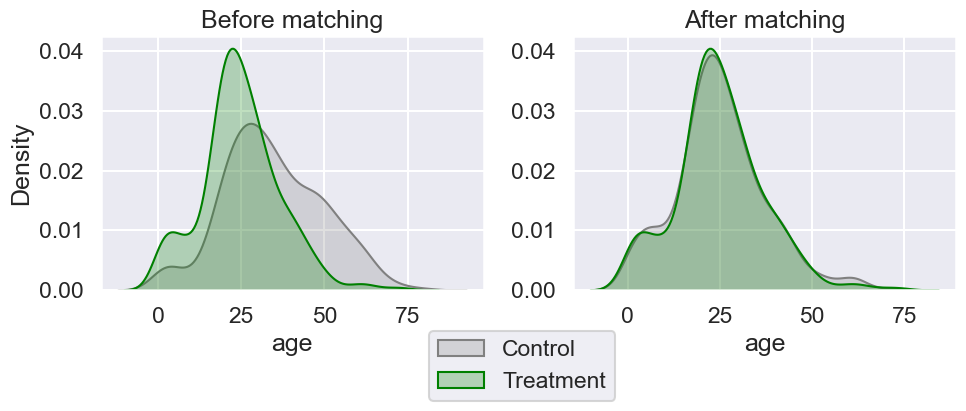

In [124]:
for var in ['logit', 'age']:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # Visualise original distribution
    sns.kdeplot(data=df[~df[TREATMENT]], x=var, fill=True, 
                color=C_COLOUR, label=C_LABEL, ax=ax[0])
    sns.kdeplot(data=df[df[TREATMENT]], x=var, fill=True, 
                color=T_COLOUR, label=T_LABEL, ax=ax[0])
    ax[0].set_title('Before matching')
    
    # Visualise new distribution
    sns.kdeplot(data=matched_df[~matched_df[TREATMENT]], x=var, 
                fill=True, color=C_COLOUR, label=C_LABEL, ax=ax[1])
    sns.kdeplot(data=matched_df[matched_df[TREATMENT]], x=var, 
                fill=True, color=T_COLOUR, label=T_LABEL, ax=ax[1])
    ax[1].set_title('After matching')
    ax[1].set_ylabel("")
    plt.tight_layout()
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3));

In [119]:
print(f"{'is_female'} | Before matching")
display(pd.crosstab(df[TREATMENT], df['is_female'], 
                    normalize='index'))
print(f"{'is_female'} | After matching")
display(pd.crosstab(matched_df[TREATMENT], matched_df['is_female'], 
            normalize='index'))

is_female | Before matching


is_female,False,True
is_pclass3,,
False,0.57,0.43
True,0.70,0.30


is_female | After matching


is_female,False,True
is_pclass3,,
False,0.69,0.31
True,0.70,0.30


Gender Ratio is also more similar

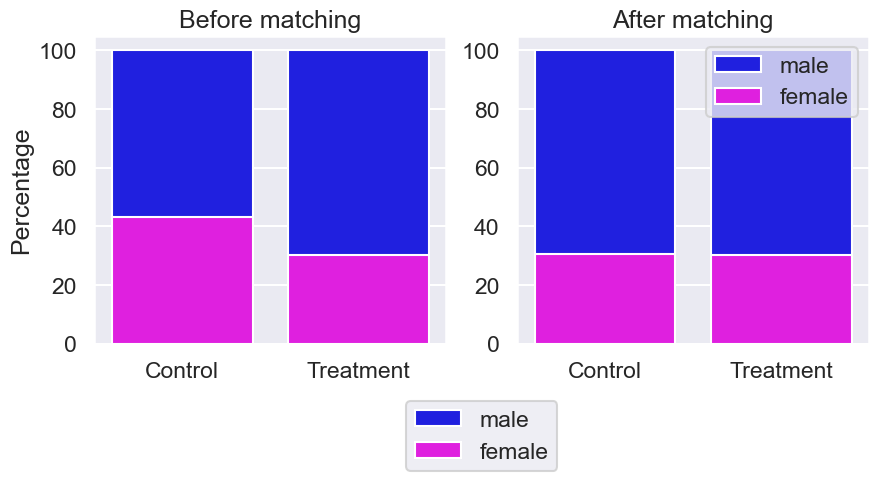

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Visualise original distribution
sns.barplot(data=gender, x=gender.index.astype(str), y="All", 
            color=M_COLOUR, label=M_LABEL, ax=ax[0])
sns.barplot(data=gender, x=gender.index.astype(str), y='female', 
            color=F_COLOUR, label=F_LABEL, ax=ax[0])
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
ax[0].set_xlabel('')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Before matching')
# Visualise new distribution
gender_after = 100 * pd.crosstab(
    matched_df[TREATMENT].replace({True: T_LABEL, False: C_LABEL}), 
    matched_df['is_female'].replace({True: 'female', False: 'Male'}), 
    normalize='index'
)
gender_after['All'] = 100
sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
            y="All", color=M_COLOUR, label=M_LABEL, ax=ax[1])
sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
            y='female', color=F_COLOUR, label=F_LABEL, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_title('After matching')
ax[1].set_ylabel('');

# 6. Evaluate Treatment Effect on Outcome

Now, it’s time to familiarize ourselves with a few terms related to the treatment effect, also known as the causal effect. Looking at a small example with a continuous outcome may be the easiest way to get familiarized with it:


<img src = "./imgs/05_img.PNG">

* fundamental problem: We don't observe both potential outcomes
* we only know the y0 for the control group and only y1 for the treatment group
* by matching the records, we attempted to proxy y0 for the treated records so that we could measure the treatment effect

* we want to estimate ATT because we did matching only for the treated records
* if we did full matching we can estimate ATE

Here’s the descriptive statistics on the outcome between the treatment and new control groups:

In [123]:
summary = matched_df.groupby(TREATMENT)[OUTCOME]\
                    .aggregate(['mean', 'std', 'count'])
summary

,mean,std,count
is_pclass3,,,
False,0.46,0.50,501
True,0.26,0.44,501


Average Treatment effect on the treated

In [125]:
c_outcome = summary.loc[False, 'mean']
t_outcome =  summary.loc[True, 'mean']
att = t_outcome - c_outcome
print('The Average Treatment Effect on Treated (ATT): {:.4f}'\
      .format(att))

The Average Treatment Effect on Treated (ATT): -0.1936


In [126]:
att = np.mean(matches['survived_t']-matches['survived_c'])
print('The Average Treatment Effect on Treated (ATT): {:.4f}'\
      .format(att))

The Average Treatment Effect on Treated (ATT): -0.1936


* assuming that we accounted for all confounding factors in our analysis, we can infer that getting a 3 class passenger cabin causes the chance to survive to drop by approx. 22 %

It's possible to use (after this exploration of a simple method) dedicated libraries such as causalinference, DoWhy or MatchIt

In [127]:
y = df[OUTCOME].values
t = df[TREATMENT].values
X = df[['is_female', 'age']]
X = pd.DataFrame(StandardScaler().fit_transform(X), 
                 columns=X.columns).values
model = CausalModel(y, t, X)
model.est_via_matching()
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.266      0.038     -6.908      0.000     -0.341     -0.190
           ATC     -0.290      0.050     -5.846      0.000     -0.388     -0.193
           ATT     -0.239      0.040     -6.035      0.000     -0.317     -0.161

